In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import copy
import seaborn as sns
import scipy
%matplotlib inline

from geneset_plotting_functions import get_geneset_cats

In [2]:
path_to_gs_data = "../../DATA/geneset_data/"
path_to_final_genes = "../../Pipeline_Outputs_Submitted/gene_rankings/"
path_to_gsea_results = "../../Pipeline_Outputs_Submitted/10k_gseapy_results/"
gset="REACTOME"


In [3]:

def query_gene_pathways(gmt_split_df, g):
 
    pathways_containing_gene = np.where([g in x for x in gmt_split_df["genes"]])[0]
    if len(pathways_containing_gene)>0:
        return gmt_split_df["names"][pathways_containing_gene].values
    else:
        return []
    
def member_cat(g, gmt, geneset_to_category):
    found_pways = query_gene_pathways(gmt, g)
    if len(found_pways)>0:
        found_cats = np.array([geneset_to_category[x] for x in found_pways])
        found, counts = np.unique(found_cats, return_counts=True)
        temp_name = found[np.argmax(counts)]
        return(temp_name, found,counts)
    else:
        return(None)
    

    
def GSEA_GSET_PROCESSING(df, gset, SIG, correction=None, replace_0_pvals=1/100000):
    gsea_df = copy.copy(df)
    
    # make sure we only get results involving the specific database
    if gset in ["KEGG", "REACTOME", "HALLMARK"]:
        gsea_df = gsea_df[gsea_df["Term"].apply(lambda x: "%s_"%gset in x)]
        gsea_df = gsea_df.reindex(np.arange(len(gsea_df)))

    toplot = gsea_df[gsea_df["pval"] < SIG]
    
    toplot["pval"] = toplot["pval"].replace(0, replace_0_pvals)
    toplot["Term"] = toplot["Term"].astype(str)    
    toplot["category"] = toplot["Term"].apply(lambda x: geneset_to_category[x])
    
    ### helpers to figure out what order to put the categories: sort by max -log10(p-value), and then sum over all -log10(p-vals)
    toplot["nlog10pval"] = toplot["pval"].apply(lambda x: -np.log10(x))
    toplot["max_nlog10pval"] = toplot["category"].apply(lambda x: toplot.groupby("category").aggregate(np.max)["nlog10pval"][x])

    toplot["sum_nlog10pval"] = toplot["category"].apply(lambda x: toplot.groupby("category").aggregate(np.sum)["nlog10pval"][x])
    toplot["sum_nlog10pval"] = toplot["sum_nlog10pval"].rank(pct=True)
    
    toplot["ORDER"] = toplot["max_nlog10pval"].astype(str) + toplot["sum_nlog10pval"].astype(str) + toplot["category"]
    
    return toplot.sort_values(["ORDER","nlog10pval"], ascending=False)


# given a list of category names (in a specified order), create a color mapper dict assigning them each to a color
# option: provide preset_color_mapper with some colors already set -- we'll then add the new cats to the not-yet-assigned colors
# note: this assumes that a consistent cmaplist was used for the previous preset_color_mapper
def get_colors_gespy_plots(ordered_cats, cmaplist, preset_color_mapper=dict()):
    if not preset_color_mapper:
        c_m = dict()
        next_i = 0
    else:
        c_m = copy.copy(preset_color_mapper)
        next_i = len(c_m.keys())
    
    for cat in ordered_cats:
        if cat not in c_m.keys():
            if next_i < len(cmaplist):
                c_m[cat] = cmaplist[next_i]
            else:
                c_m[cat] = cmaplist[-1]
            next_i += 1
    return c_m

In [4]:
gene_symbols = np.loadtxt(path_to_gs_data + "genesymbols.txt", dtype="str")


CONSENSUS_SCORES = {}
for var in ["all"]:
    for model in ["Correlations", "MTL"]:
        CONSENSUS_SCORES["%s~%s-related"%(model,var)] = pd.read_csv(path_to_final_genes + "%s/%s-related.rnk"%(model,var), sep="\t", header=None, names=["gene", "score"]).sort_values("score", ascending=False).reset_index(drop=True)
for key in CONSENSUS_SCORES.keys():
    CONSENSUS_SCORES[key]["abs_score"] = CONSENSUS_SCORES[key]["score"].apply(lambda x: (x-.5)*2 if x>=.5 else (.5-x)*2)
    CONSENSUS_SCORES[key]["gene_sign"] = CONSENSUS_SCORES[key]["score"].apply(lambda x: " +" if x>.5 else "  - ")
    
        
# SET PATH TO GENE SETS
gmt_locations = {"REACTOME": path_to_gs_data + 'c2.all.v7.0.symbols_JustR.gmt',
                "KEGG": path_to_gs_data + 'c2.all.v7.0.symbols_JustK.gmt',
                "HALLMARK": path_to_gs_data + 'h.all.v7.0.symbols.gmt'}
for gs in ["mathys_celltypes", "sara_modules", "ben_modules", "mathys_microglia", "olah_microglia"]:
    gmt_locations[gs] = path_to_gs_data + "%s/processed/gene_set.gmt"%gs
    

# SET COLORS
cmap=plt.cm.tab20
cmaplist =  [cmap(i) for i in range(cmap.N)]
missing_color="#eeeeee"


# LOAD GSET INFO
gmt, category_to_geneset, geneset_to_category = get_geneset_cats(gset, path_to_gs_data, gmt_locations)

# enrichment bar plots

In [5]:
sourcedata_cols = ['Term', 'category', 'es', 'nes', 'pval', 'fdr', 'geneset_size', 'matched_size']
sourcedata_file_mapper = {
    ("REACTOME", "MTL"): "sourcedata/4b_MDAD_finalgenes_enrichment_REACTOME.csv",
    ("mathys_celltypes", "MTL"):"sourcedata/6c_MDAD_finalgenes_enrichment_celltypes.csv",
    ("REACTOME", "Correlations"): "sourcedata/supp7b_corr_finalgenes_enrichment_REACTOME.csv",
    ("KEGG", "Correlations"): "sourcedata/supp8b_corr_finalgenes_enrichment_KEGG.csv",
    ("KEGG", "MTL"):"sourcedata/supp8a_MDAD_finalgenes_enrichment_KEGG.csv"    
}


/homes/gws/nbbwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/homes/gws/nbbwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/homes/gws/nbbwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

46
saved to sourcedata/4b_MDAD_finalgenes_enrichment_REACTOME.csv
180
saved to sourcedata/supp7b_corr_finalgenes_enrichment_REACTOME.csv


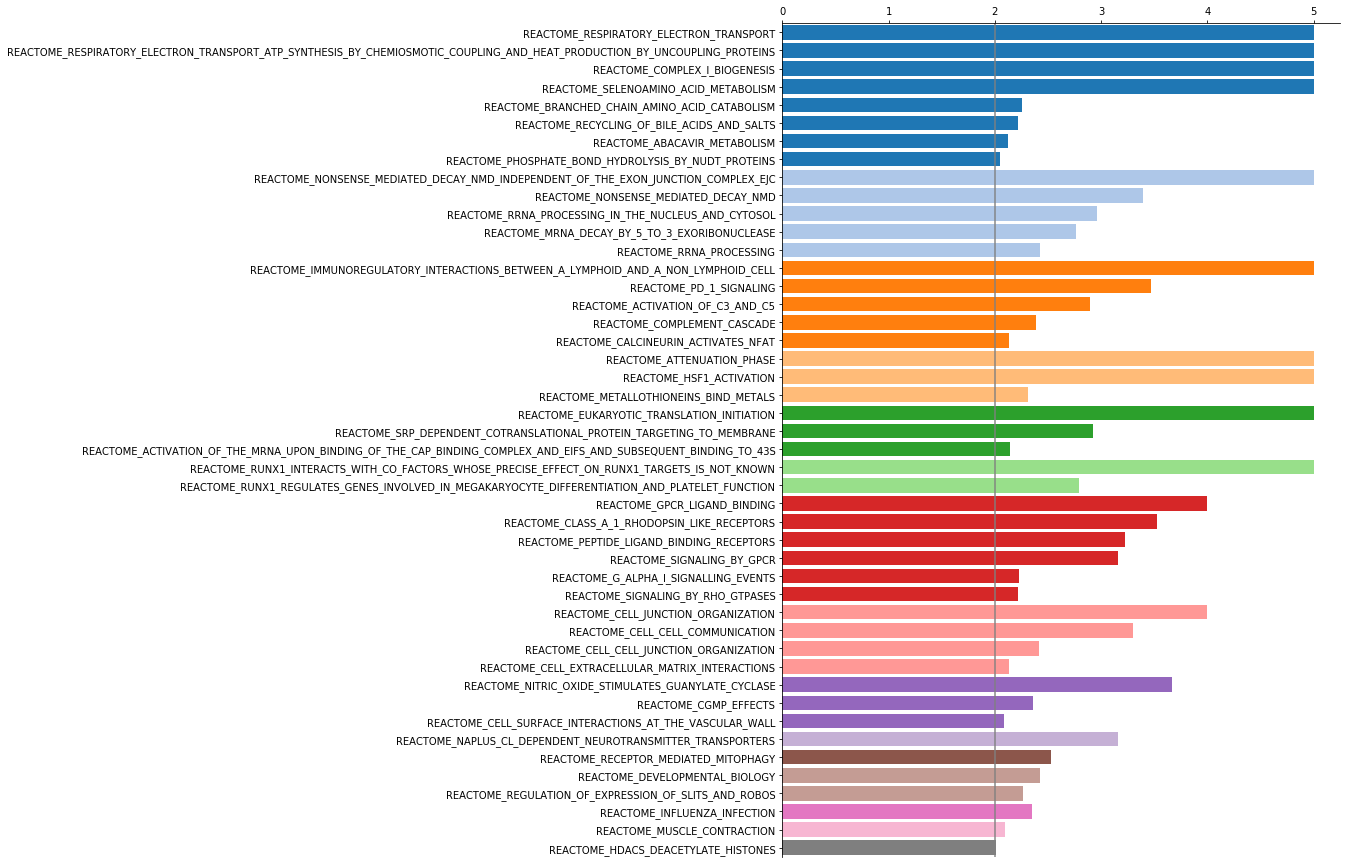

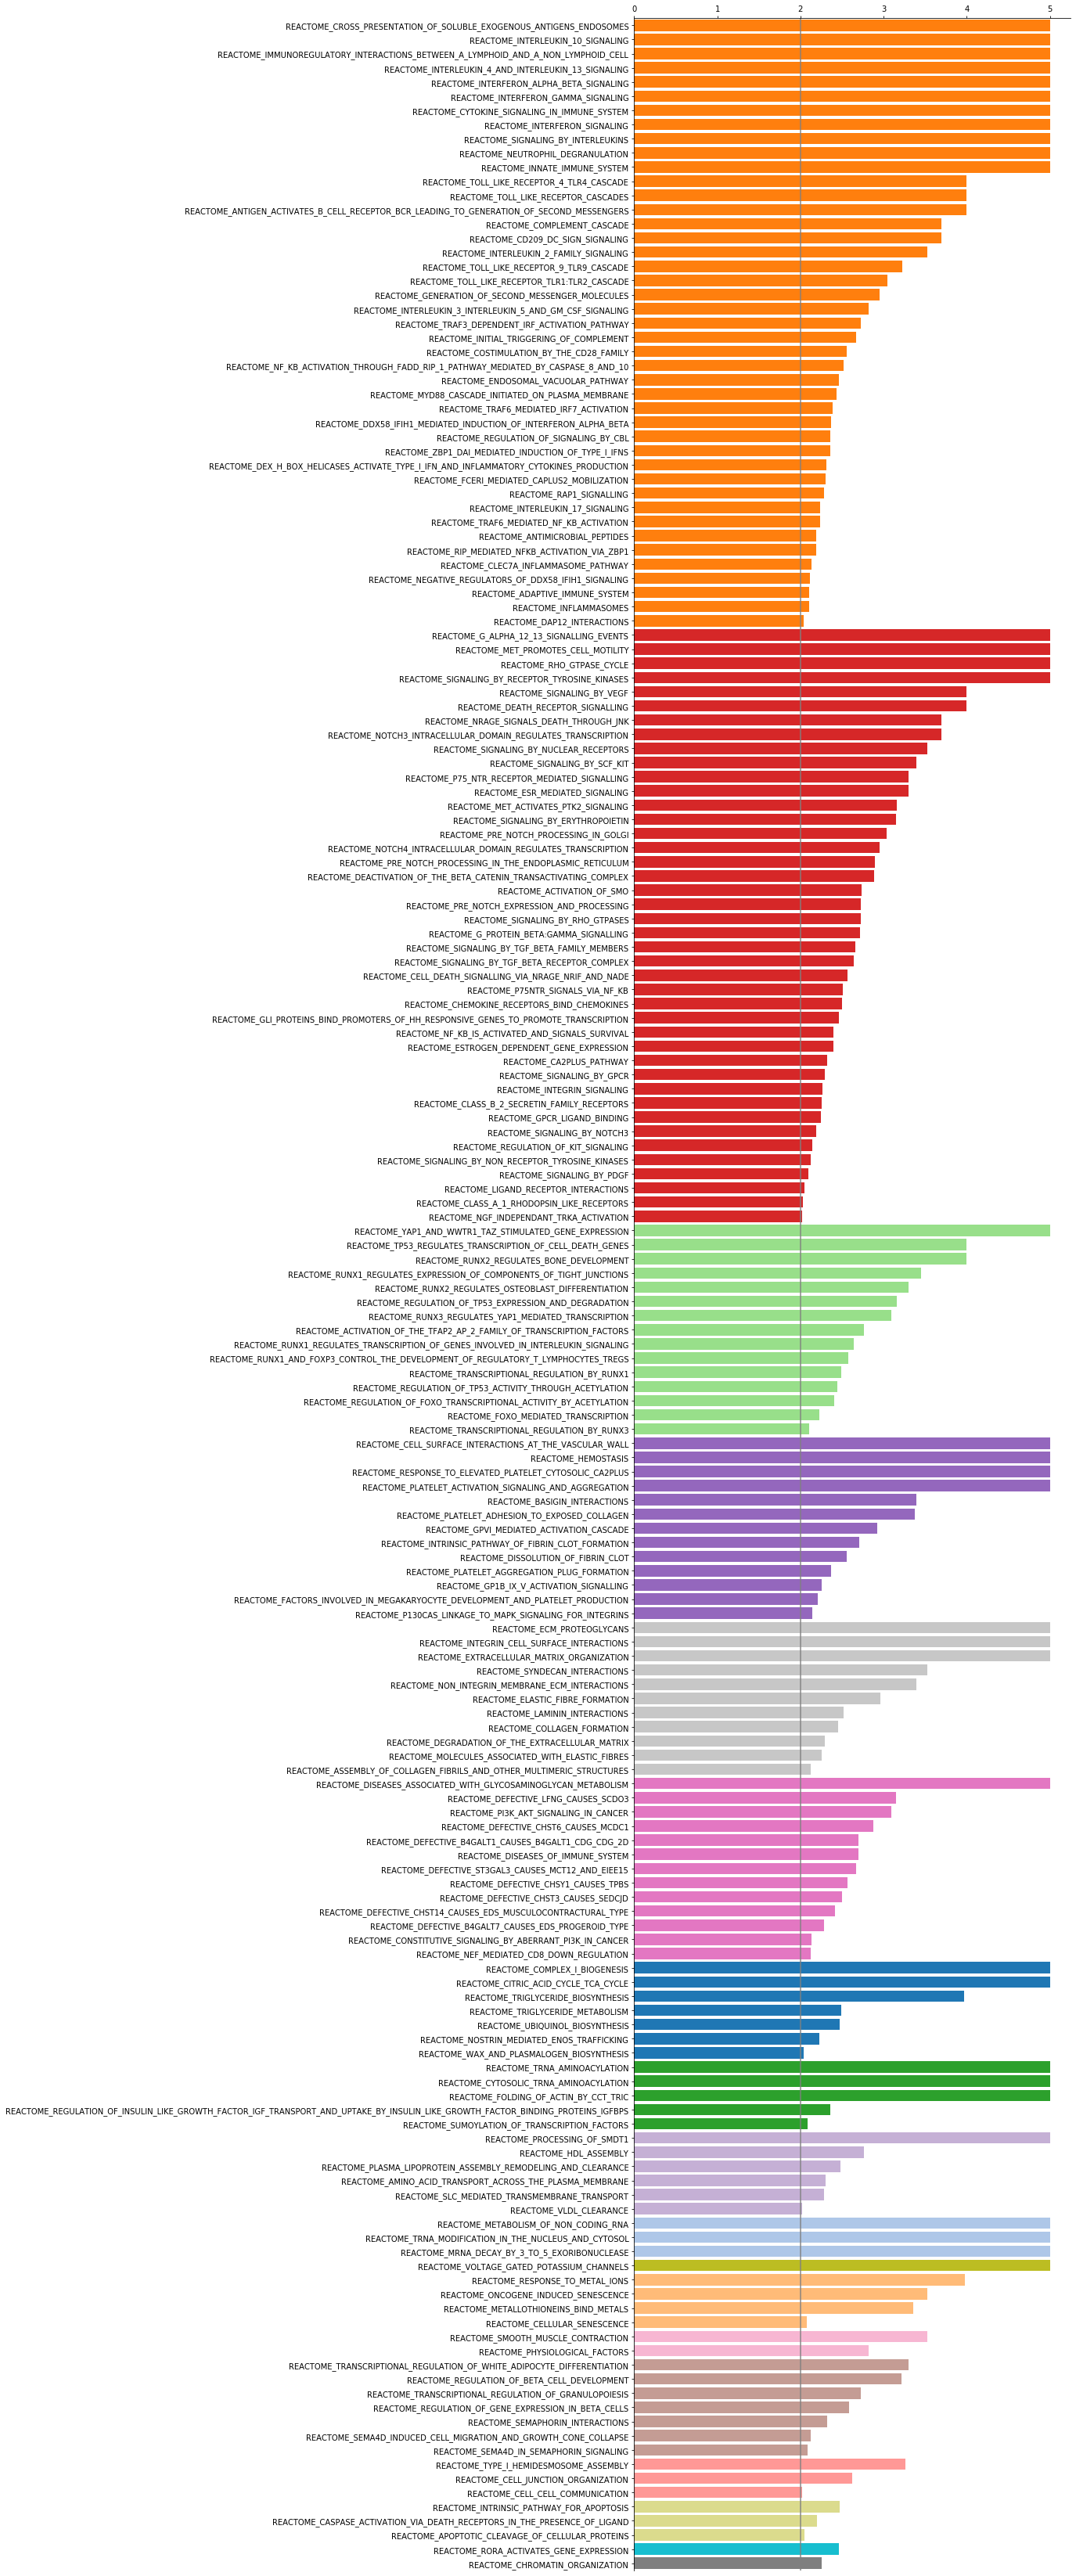

In [6]:
LISTNAMEs = ["MTL", "Correlations"]
SIG=0.01




color_mapper = {}
cmappers_for_method = {}

for LISTNAME in LISTNAMEs:
    
    gsea_df = pd.read_csv("%sfinal_genes/%s/%s/all-related/gseapy.prerank.gene_sets.report.csv"%(path_to_gsea_results, LISTNAME,gset))
    df = GSEA_GSET_PROCESSING(gsea_df, gset, SIG, correction=None, replace_0_pvals=1/100000)

    color_mapper = get_colors_gespy_plots(df["category"].unique(), cmaplist, color_mapper)
    cmappers_for_method[LISTNAME]=color_mapper
    
    if len(df)>0:
        plt.figure(figsize=(10,len(df)/3))
        df["color_for_bars"] = df["category"].apply(lambda x: color_mapper[x] if x in color_mapper.keys() else missing_color)
        ax=sns.barplot(x="nlog10pval", y="Term", data=df, palette=df["color_for_bars"], dodge=False, saturation=1, orient="horizontal")
        ax.axvline(-np.log10(SIG), color='gray', lw=2, alpha=.7)
        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)
        ax.xaxis.set_ticks_position('top')
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_facecolor('None')
        
    print(len(df))
    
    if (gset,LISTNAME) in sourcedata_file_mapper:
        sourcedata = df[sourcedata_cols]
        sourcedata.to_csv(sourcedata_file_mapper[(gset,LISTNAME)], index=False)
        print("saved to %s"%sourcedata_file_mapper[(gset,LISTNAME)])

In [7]:
## PRINT OUT LABELS IN PLAIN TEXT
# if gset in ["KEGG"]:
#     import requests
#     import urllib.request
#     from bs4 import BeautifulSoup
#     for pway in df["Term"]:
#         url = "http://software.broadinstitute.org/gsea/msigdb/cards/%s"%pway
#         response = requests.get(url)

#         soup = BeautifulSoup(response.text, "html.parser")
#         td_tags = soup.find_all("td")
#         print(td_tags[5].text)
# else:
#     for pway in df["Term"]:
#         print(pway)

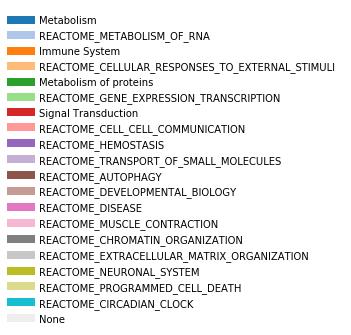

In [8]:
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=c, lw=8) for c in list(color_mapper.values())+["#eeeeee"]]
ax = plt.subplot()  #create the axes 
ax.set_axis_off()  #turn off the axis 
num_cols = int(np.ceil((len(color_mapper.keys()) + 1)/12))
num_cols=1

ax.legend(custom_lines,  list(color_mapper.keys())+["None"], frameon=False, ncol=num_cols)
plt.show() 

In [9]:
## PRINT OUT LEGEND IN PLAIN TEXT
# for elt in list(color_mapper.keys())+["None"]: print(elt)

# get colored lists

In [10]:
topx = 50

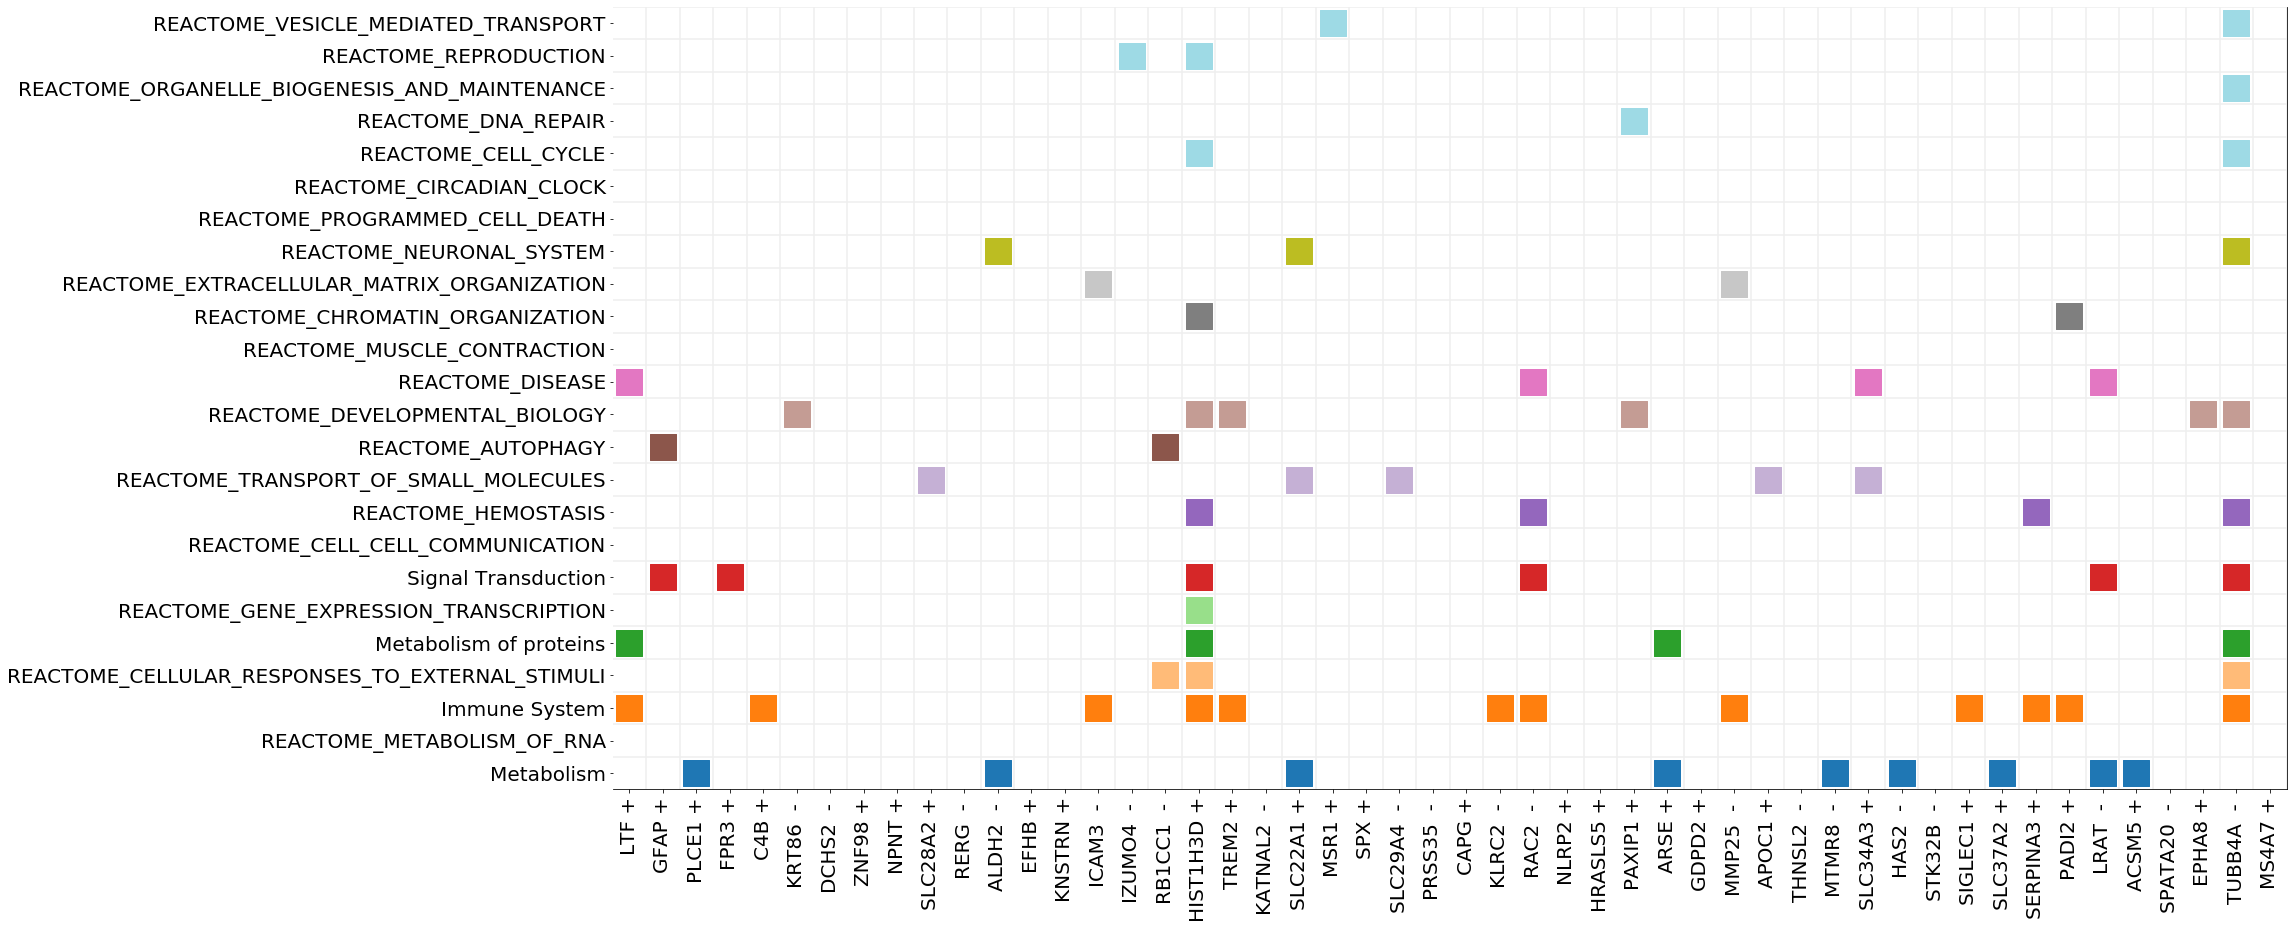

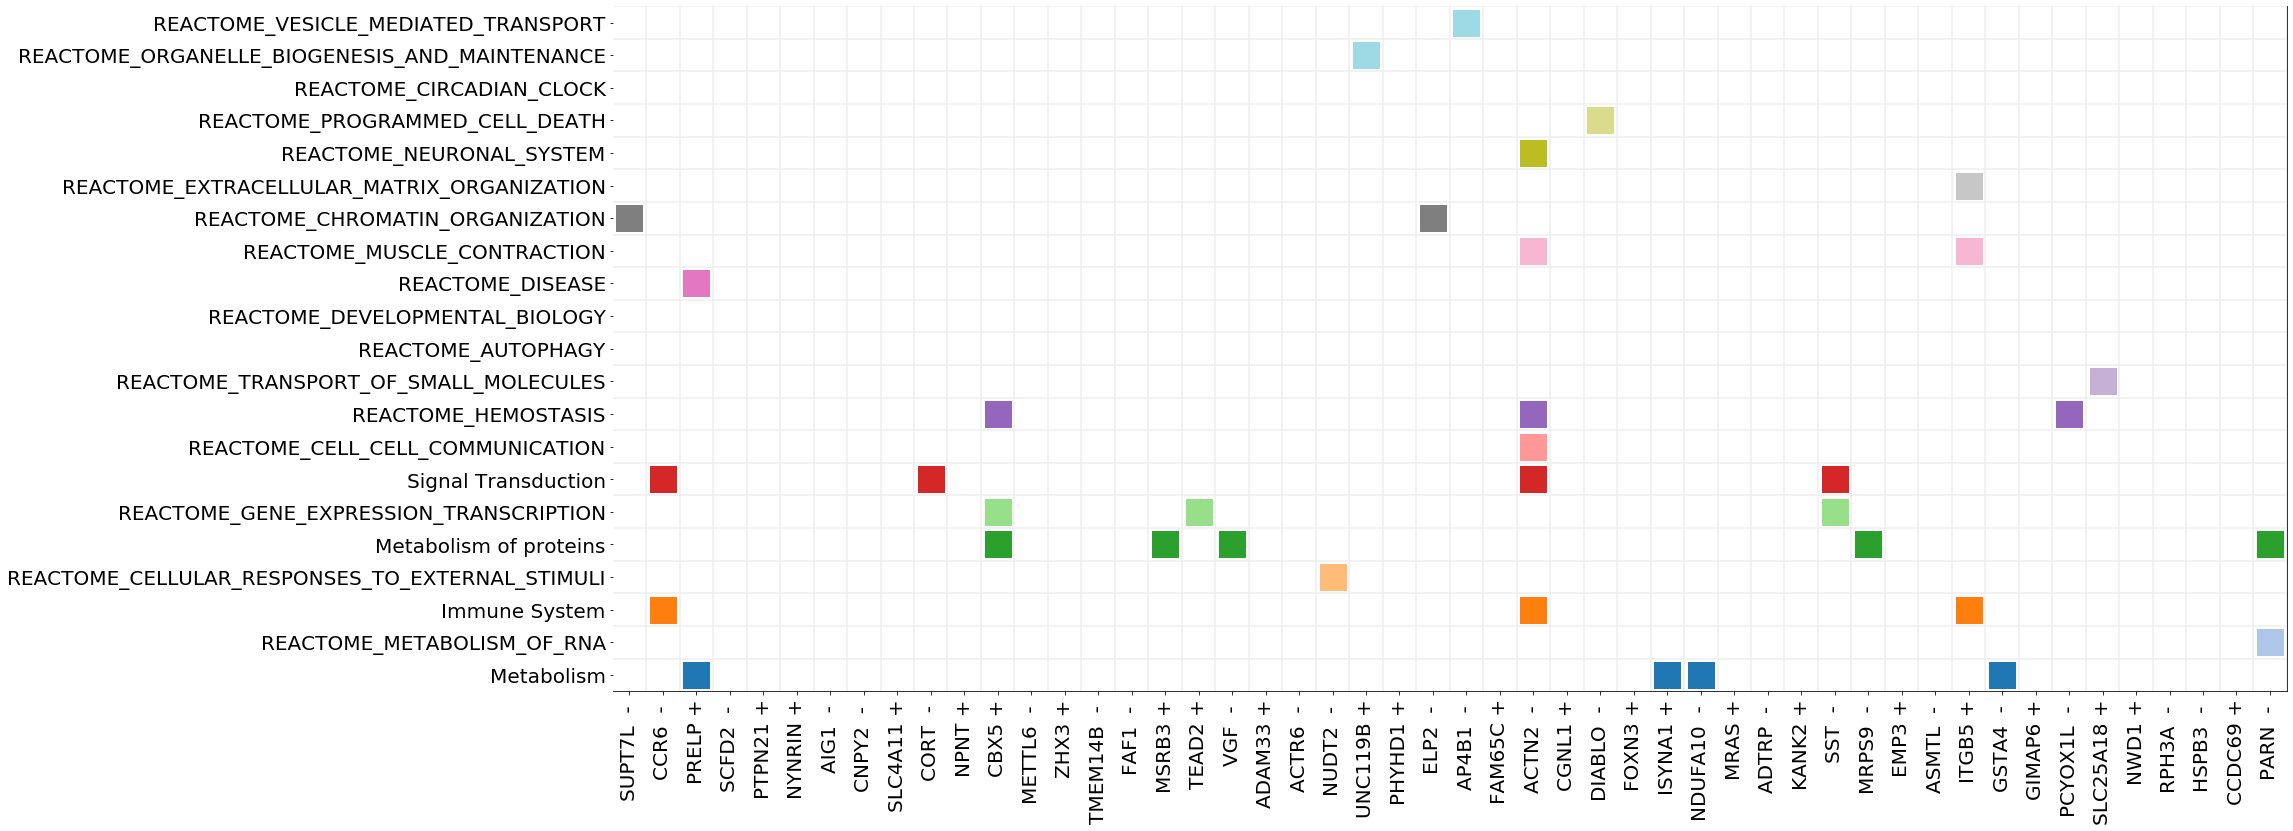

In [11]:
most_pos={}
most_neg={}
top_genes={}
for method in ["MTL~all-related", "Correlations~all-related"]:
    top_genes[method] = CONSENSUS_SCORES[method].sort_values("abs_score", ascending=False)[:topx]
    top_genes[method]["gene_set"] = top_genes[method]["gene"].apply(lambda x: member_cat(x, gmt, geneset_to_category))
    all_extreme_genes = top_genes[method]["gene"].values

    cat_hits_df = pd.DataFrame(0, columns=category_to_geneset.keys(), index=all_extreme_genes)

    for elt in all_extreme_genes:
        res = member_cat(elt, gmt, geneset_to_category)
        if res:
            for i,name in enumerate(res[1]):
                if name != "UNKNOWN":
                    cat_hits_df.at[elt,name] = res[2][i]


    non_zero_cols = cat_hits_df.columns[cat_hits_df.sum(axis=0) > 0]
    gsea_cats = list(color_mapper.keys())
    non_gsea_cats = np.setdiff1d(non_zero_cols, gsea_cats)
    cols_appearing_in_plot = np.append(gsea_cats,non_gsea_cats)[::-1]
    cat_hits_df_toplot=cat_hits_df[cols_appearing_in_plot]

    temp_color_mapper = copy.copy(cmappers_for_method[method.split("~")[0]])

    set_colors_from_before = list(temp_color_mapper.keys())

    missed_top_cats = np.setdiff1d(cols_appearing_in_plot, set_colors_from_before, assume_unique=True)[::-1]

    num_to_add =len(cmaplist) - len(set_colors_from_before)
    for i,group in enumerate(missed_top_cats[:num_to_add-1]):
        temp_color_mapper[group] = cmaplist[i+len(set_colors_from_before)]
    for group in missed_top_cats[num_to_add-1:]:
        temp_color_mapper[group] = cmaplist[-1]
    width = 30
    width_height_ratio = cat_hits_df_toplot.shape[1]/cat_hits_df_toplot.shape[0]
    fig, ax = plt.subplots(1,1, figsize=(width, width*width_height_ratio)) 

    col_order = cat_hits_df_toplot.columns[::-1]

    for col_idx,col in enumerate(col_order):
        gene_idxs = np.where(cat_hits_df_toplot[col])[0]
        ax.scatter(gene_idxs, [col_idx]*len(gene_idxs), color = temp_color_mapper[col], marker="s", s=(width/topx * 1100))
    ax.set_xticks(np.arange(cat_hits_df_toplot.shape[0]))
    ax.set_yticks(np.arange(cat_hits_df_toplot.shape[1]))
    # ax.yaxis.tick_right()


    # Set ticks labels for x-axis
    for i in np.arange(cat_hits_df_toplot.shape[0]):
        ax.axvline(i + .5, alpha=1, c=missing_color)
    for i in np.arange(cat_hits_df_toplot.shape[1]):
        ax.axhline(i + .5, alpha=1, c=missing_color)


    signs = CONSENSUS_SCORES[method].set_index("gene").loc[cat_hits_df_toplot.index.values]["gene_sign"].values
    ax.set_xticklabels(cat_hits_df_toplot.index.values + signs, rotation='vertical', fontsize=20);

    ax.set_yticklabels(col_order, rotation='horizontal', fontsize=20);
    ax.set_ylim(-.5, cat_hits_df_toplot.shape[1]-.5)
    ax.set_xlim(-.5, cat_hits_df_toplot.shape[0]-.5)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_facecolor('None')
    ax.xaxis.label.set_visible(False)
    ax.yaxis.label.set_visible(False)
    
## PRINT OUT LABELS IN PLAIN TEXT
#     print("LABELS:")
#     for x in col_order.values: print(x)
#     print("GENES:")
#     for x in cat_hits_df_toplot.index.values[:100] + signs[:100]: print(x)

### Sourcedata for 4a and 4c

In [12]:
all_genes_genesets = pd.DataFrame(0, columns=category_to_geneset.keys(), index=gene_symbols)

for elt in gene_symbols:
    res = member_cat(elt, gmt, geneset_to_category)
    if res:
        for i,name in enumerate(res[1]):
            if name != "UNKNOWN":
                all_genes_genesets.at[elt,name] = 1

In [13]:
if "UNKNOWN" in all_genes_genesets.columns:
    all_genes_genesets= all_genes_genesets.drop("UNKNOWN", axis=1)
all_genes_genesets = all_genes_genesets.reset_index().rename(columns={'index':'gene'})

ranked_genes_df = {}
for method in ["MTL~all-related", "Correlations~all-related"]:
    ranked_genes_df[method] = CONSENSUS_SCORES[method]
    ranked_genes_df[method]["ranked_genes"] = scipy.stats.rankdata(ranked_genes_df[method]["abs_score"])/len(ranked_genes_df[method])

    ranked_genes_df[method] = ranked_genes_df[method][["gene", "ranked_genes", "gene_sign"]]
    
    

both_ranks = pd.merge(ranked_genes_df["MTL~all-related"], ranked_genes_df["Correlations~all-related"], on="gene", suffixes=("_MD-AD", "_correlations"))


In [14]:
sourcedata = both_ranks.merge(all_genes_genesets, on="gene")

In [15]:
if gset=="REACTOME":
    sourcedata.to_csv("sourcedata/4ac_gene_ranks_REACTOME.csv", index=False)
elif gset=="olah_microglia":
    sourcedata.to_csv("sourcedata/6a_gene_ranks_microglial_clusters.csv", index=False)